# Grafové neurónové siete

Grafové neurónové siete sú modely, ktoré pracujú s grafovými dátami a môžu byť využité okrem iného na klasifikáciu textu, v odporúčacích systémoch, v predpovedaní premávky a pri vývoji nových liekov.

Grafy sú abstraktné a nelineárne údajové štruktúry, ktoré vyjadrujú vzťah medzi rôznymi jednotkami údajov. Môžu byť orientované alebo neorientované, a vážené alebo nevážené (v uzloch, v hranách a v oboch). Graf je vo všetkých týchto prípadoch reprezentovaný cez maticu susednosti, kde každá hodnota je 0 alebo 1, vyjadrujúca existenciu resp. neexistenciu spojenia medzi dvomi uzlami. Pri neorientovaných grafoch platí, že $x_{ij} = x_{ji}$.

![](lab09/molecule.jpg)

## Konvolúcia nad grafmi

Podobne ako obrázky, aj grafy spĺňajú niekoľko kritérií, ktoré ich predurčujú na úspešné spracovanie konvolúciou. Aj pre nich platí lokalita, teda súvisiace údaje a informácie sú uložené zvyčajne blízko seba (vrchol vzdialený o jednu hranu bude relevantnejší ako vrchol vzdialený niekoľko hrán). Pre grafy navyše platí permutačná invariancia, teda môžeme pomiešať poradie uzlov, a reprezentácia grafu sa nemení. Konvolúcia dokáže úspešne pracovať s takouto invarianciou, a počet parametrov stále nezávisí od veľkosti vstupu. V skutočnosti existuje niekoľko konvolučných prístupov pre spracovanie grafových dát, a ďalšie sú stále predmetom výskumu.

Majme nasledovný graf:

In [1]:
import numpy as np
import networkx as nx

G = nx.Graph()
blue, orange, green = "#1f77b4", "#ff7f0e", "#2ca02c"
G.add_nodes_from([
    (1, {"color": blue}),
    (2, {"color": orange}),
    (3, {"color": blue}),
    (4, {"color": green})
])
G.add_edges_from([(1,2), (2,3), (1,3), (3,4)])
A = np.asarray(nx.adjacency_matrix(G).todense())
print(A)

[[0 1 1 0]
 [1 0 1 0]
 [1 1 0 1]
 [0 0 1 0]]


In [2]:
def build_graph_color_label_representation(G, mapping_dict):
    one_hot_idxs = np.array([mapping_dict[v] for v in
    nx.get_node_attributes(G, 'color').values()])

    one_hot_encoding = np.zeros((one_hot_idxs.size, len(mapping_dict)))
    one_hot_encoding[np.arange(one_hot_idxs.size), one_hot_idxs] = 1
    return one_hot_encoding

X = build_graph_color_label_representation(G, {green: 0, blue: 1, orange: 2})
print(X)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


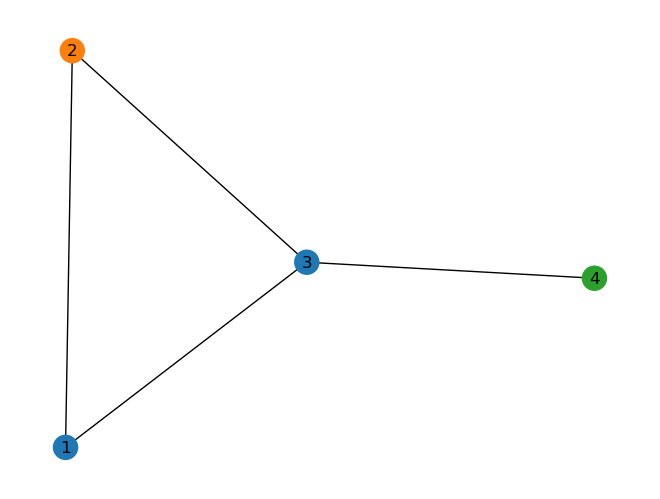

In [3]:
color_map = nx.get_node_attributes(G, 'color').values()
nx.draw(G,with_labels=True, node_color=color_map)

Grafová konvolúcia aktualizuje embedding jednotlivých uzlov (každému prislúcha jeden riadok v matici) s informáciami o samotnom uzle a jeho susedoch. Konvolúcia môže prebiehať napríklad:

$$x'_{i} = x_i \cdot W_1 + \sum_{j \in N(i)} x_j \cdot W_2 + b,$$

kde $W_1$ a $W_2$ sú trénovateľné váhy (s rozmermi $f_{in} \times f_{out}$) a $b$ je trénovateľný bias (s rozmermi $f_{out}$). Úlohou váh je slúžiť ako filtre a berú do úvahy iba priame spojenia. Pre zohľadnenie vzťahov o niekoľko hrán musíme použiť viacnásobnú konvolúciu. Potom pomocou matice susednosti vieme vypočítať požadované hodnoty:

In [4]:
f_in, f_out = X.shape[1], 6
W_1 = np.random.rand(f_in, f_out)
W_2 = np.random.rand(f_in, f_out)
h = np.dot(X, W_1) + np.dot(np.dot(A, X), W_2)
print(h)

[[0.41378164 1.83714766 2.08174987 1.87363916 0.70633165 2.2845742 ]
 [0.9373795  2.00647898 2.26163536 1.47160171 0.52226967 1.98331539]
 [1.41091572 2.22913178 2.66401564 2.40839012 0.74541736 2.39353277]
 [1.16761232 1.48022188 1.14367041 0.50390543 0.53960779 1.08661062]]


Rôzne grafové konvolúcie majú jednotnú schému spracovania cez posielanie správ, kde každý uzol má svoj vlastný skrytý stav $h_i^{(t)}$, pričom $h_i^{(0)} = x_i$ (riadok pre uzol *i*). Následne sa konvolúcia vykoná v dvoch fázach:

1. fáza posielania správ - pre každý uzol sa vypočíta hodnota funkcie správy (*message function*):
$$m_i = \sum_{j \in N(i)} M_t(h_i^{(t)}, h_j^{(t)}, e_{ij}),$$
kde $M_t$ je funkcia správy.
2. fáza aktualizácie vrcholov - skrytý stav vrcholov sa aktualizuje podľa:
$$h_i^{(t+1)} = U_t(h_i^{(t)}, m_i)$$

**Poznámka:** Pre orientované grafy sa susednosť definuje cez hrany smerujúce do uzla *i*.

## Definícia grafovej siete v PyTorchi

In [5]:
import networkx as nx
import torch
from torch.nn.parameter import Parameter
import numpy as np
import math
import torch.nn.functional as F

class NodeNetwork(torch.nn.Module):
    def __init__(self, input_features):
        super().__init__()
        # network with two graph convolutions
        self.conv_1 = BasicGraphConvolutionLayer(input_features, 32)
        self.conv_2 = BasicGraphConvolutionLayer(32, 32)
        self.fc_1 = torch.nn.Linear(32, 16)
        self.out_layer = torch.nn.Linear(16, 2)

    def forward(self, X, A, batch_mat):
        x = F.relu(self.conv_1(X, A))
        x = F.relu(self.conv_2(x, A))
        # use global pooling for dealing with graphs of varying sizes
        output = global_sum_pool(x, batch_mat)
        output = self.fc_1(output)
        output = self.out_layer(output)
        return F.softmax(output, dim=1)

Štruktúra siete je vizualizovaná na nasledujúcom obrázku:

![](lab09/structure.jpg)

In [6]:
class BasicGraphConvolutionLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        # generate random weights and biases
        self.W2 = Parameter(torch.rand(
            (in_channels, out_channels), dtype=torch.float32))
        self.W1 = Parameter(torch.rand(
            (in_channels, out_channels), dtype=torch.float32))
        self.bias = Parameter(torch.zeros(
            out_channels, dtype=torch.float32))

    def forward(self, X, A):
        potential_msgs = torch.mm(X, self.W2)
        propagated_msgs = torch.mm(A, potential_msgs)
        root_update = torch.mm(X, self.W1)
        output = root_update + propagated_msgs + self.bias
        return output

Príklad použitia grafovej konvolúcie:

In [7]:
print('X.shape:', X.shape)
print('A.shape:', A.shape)

basiclayer = BasicGraphConvolutionLayer(3, 8)
out = basiclayer(
    X=torch.tensor(X, dtype=torch.float32),
    A=torch.tensor(A, dtype=torch.float32)
)
print('Output shape:', out.shape)

X.shape: (4, 3)
A.shape: (4, 4)
Output shape: torch.Size([4, 8])


Cieľom globálneho *pooling*u je agregovať všetky uzlové embeddingy grafu do jednotnej veľkosti (podobne ako pri spracovaní obrazu cez global average pooling). Pooling môže fungovať na základe funkcií, ktoré sú invariantné voči permutáciám (napríklad suma, maximum, priemer):

In [8]:
def global_sum_pool(X, batch_mat):
    if batch_mat is None or batch_mat.dim() == 1:
        return torch.sum(X, dim=0).unsqueeze(0)
    else:
        return torch.mm(batch_mat, X)

Vytváranie mini-batchov pri grafoch nie je také priamočiare ako v prípade obrázkov, najmä vzhľadom na to, že grafy môžu mať rôzne veľkosti. Tento problém sa dá obísť paddingom, čo ale stále nefunguje ideálne v prípade, že veľkosť grafov sa líši vo väčšej miere. Práve preto mini-batch je často reprezentovaný ako jeden graf s niekoľkými nespojenými podgrafmi.

In [9]:
def get_batch_tensor(graph_sizes):
    starts = [sum(graph_sizes[:idx])
              for idx in range(len(graph_sizes))]
    stops = [starts[idx] + graph_sizes[idx]
             for idx in range(len(graph_sizes))]
    tot_len = sum(graph_sizes)
    batch_size = len(graph_sizes)
    batch_mat = torch.zeros([batch_size, tot_len]).float()
    for idx, starts_and_stops in enumerate(zip(starts, stops)):
        start = starts_and_stops[0]
        stop = starts_and_stops[1]
        batch_mat[idx,start:stop] = 1
    return batch_mat

In [10]:
# batch is a list of dictionaries each containing
# the representation and label of a graph
def collate_graphs(batch):
    adj_mats = [graph['A'] for graph in batch]
    sizes = [A.size(0) for A in adj_mats]
    tot_size = sum(sizes)
    # create batch matrix
    batch_mat = get_batch_tensor(sizes)
    # combine feature matrices
    feat_mats = torch.cat([graph['X'] for graph in batch], dim=0)
    # combine labels
    labels = torch.cat([graph['y'] for graph in batch], dim=0)
    # combine adjacency matrices
    batch_adj = torch.zeros([tot_size, tot_size], dtype=torch.float32)
    accum = 0
    for adj in adj_mats:
        g_size = adj.shape[0]
        batch_adj[accum:accum+g_size,accum:accum+g_size] = adj
        accum = accum + g_size
    repr_and_label = {'A': batch_adj,
                      'X': feat_mats, 'y': labels,
                      'batch': batch_mat}
    return repr_and_label

## Vytvorenie grafov a príprava údajov

In [11]:
def get_graph_dict(G, mapping_dict):
    # Function builds dictionary representation of graph G
    A = torch.from_numpy(
        np.asarray(nx.adjacency_matrix(G).todense())).float()
    # build_graph_color_label_representation()
    # was introduced with the first example graph
    X = torch.from_numpy(
        build_graph_color_label_representation(
            G, mapping_dict)).float()
    # kludge since there is not specific task for this example
    y = torch.tensor([[1,0]]).float()
    return {'A': A, 'X': X, 'y': y, 'batch': None}

In [12]:
blue, orange, green = "#1f77b4", "#ff7f0e","#2ca02c"
mapping_dict= {green:0, blue:1, orange:2}
G1 = nx.Graph()
G1.add_nodes_from([
    (1,{"color": blue}),
    (2,{"color": orange}),
    (3,{"color": blue}),
    (4,{"color": green})
])
G1.add_edges_from([(1, 2), (2, 3), (1, 3), (3, 4)])

G2 = nx.Graph()
G2.add_nodes_from([
    (1,{"color": green}),
    (2,{"color": green}),
    (3,{"color": orange}),
    (4,{"color": orange}),
    (5,{"color": blue})
])
G2.add_edges_from([(2, 3),(3, 4),(3, 1),(5, 1)])

G3 = nx.Graph()
G3.add_nodes_from([
    (1,{"color": orange}),
    (2,{"color": orange}),
    (3,{"color": green}),
    (4,{"color": green}),
    (5,{"color": blue}),
    (6,{"color":orange})
])
G3.add_edges_from([(2,3), (3,4), (3,1), (5,1), (2,5), (6,1)])

G4 = nx.Graph()
G4.add_nodes_from([
    (1,{"color": blue}),
    (2,{"color": blue}),
    (3,{"color": green})
])
G4.add_edges_from([(1, 2), (2, 3)])
graph_list = [
    get_graph_dict(graph, mapping_dict) for graph in [G1, G2, G3, G4]
]

In [13]:
from torch.utils.data import Dataset

class ExampleDataset(Dataset):
    # Simple PyTorch dataset that will use our list of graphs
    def __init__(self, graph_list):
        self.graphs = graph_list

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self,idx):
        mol_rep = self.graphs[idx]
        return mol_rep

In [14]:
from torch.utils.data import DataLoader

dset = ExampleDataset(graph_list)
loader = DataLoader(
    dset, batch_size=2, shuffle=False,
    collate_fn=collate_graphs
)

## Generovanie predikcií

In [15]:
node_features = 3
net = NodeNetwork(node_features)
batch_results = []
for b in loader:
    batch_results.append(net(b['X'], b['A'], b['batch']).detach())
print(batch_results)

[tensor([[1.0000e+00, 3.8706e-07],
        [1.0000e+00, 9.4998e-08]]), tensor([[1.0000e+00, 2.2119e-11],
        [9.9850e-01, 1.5048e-03]])]


In [16]:
G2_rep = dset[1]
G2_single = net(G2_rep['X'], G2_rep['A'], G2_rep['batch']).detach()
print(G2_single)

tensor([[1.0000e+00, 9.4997e-08]])


In [17]:
G2_batch = batch_results[0][1]
print(G2_batch)

tensor([1.0000e+00, 9.4998e-08])


In [18]:
torch.all(torch.isclose(G2_single, G2_batch))

tensor(True)

## Príklady

* [Definícia a trénovanie GNN pomocou PyTorch Geometric](https://github.com/rasbt/machine-learning-book/blob/main/ch18/ch18_part2.ipynb)

## Použité zdroje

* Raschka, Sebastian, Yuxi Hayden Liu, Vahid Mirjalili, and Dmytro Dzhulgakov. Machine Learning with PyTorch and Scikit-Learn: Develop machine learning and deep learning models with Python. Packt Publishing Ltd, 2022. Kapitola 18
* Dehmamy, Nima, Albert-László Barabási, and Rose Yu. "Understanding the representation power of graph neural networks in learning graph topology." Advances in Neural Information Processing Systems 32 (2019).
* Gilmer, Justin, Samuel S. Schoenholz, Patrick F. Riley, Oriol Vinyals, and George E. Dahl. "Neural message passing for quantum chemistry." In International conference on machine learning, pp. 1263-1272. PMLR, 2017.